In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, log_loss, roc_auc_score, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import VotingClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import tarfile
import optuna
import json
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import cross_val_score, train_test_split
import lightgbm as lgb
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import xgboost as xgb
from scipy.stats import mode

In [12]:
# Function to extract our files for tar archive
def extract_csv_from_tar(tar_path):
    dataframes = []
    with tarfile.open(tar_path, 'r') as tar:
        # Iterate over each member in the tar archive
        for member in tar.getmembers():
            if member.isfile() and member.name.endswith('.csv'):
                # Extract the file object
                file_obj = tar.extractfile(member)
                # Read the CSV file into a DataFrame
                df = pd.read_csv(file_obj)
                # Append the DataFrame to the list
                dataframes.append(df)
    return dataframes

In [13]:
#Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, title):
    conf_matrix = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds', xticklabels=[1, 2, 3, 4, 5], yticklabels=[1, 2, 3, 4, 5])
    plt.xlabel('Predicted Class')
    plt.ylabel('Actual Class')
    plt.title(title)
    plt.show()

In [14]:
# Function to plot auc-roc curve
def plot_auc_roc_curve(model, X_test, y_test):
    # Predict the probabilities for the positive class
    y_prob = model.predict_proba(X_test)[:, 1]
    
    # Compute the ROC curve and ROC area
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    
    # Plot the AUC-ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

In [15]:
# Path to not_null target speed file
tar_path_train = '/Users/grigorijcebotarev/Desktop/thesis/notnull_features.tar.gz'
all_features_speed_not_null = extract_csv_from_tar(tar_path_train)

# Path to null target speed file
tar_path_test = '/Users/grigorijcebotarev/Desktop/thesis/null_features.tar.gz'
all_features_speed_null = extract_csv_from_tar(tar_path_test)
len(all_features_speed_not_null)

2635

In [16]:
# Joining users.csv to have age and english_spoken as additional features
users = pd.read_csv("users.csv")
for i in range(len(all_features_speed_not_null)):
    all_features_speed_not_null[i] = pd.merge(all_features_speed_not_null[i], users[['user_id','age', 'english_spoken']], on = 'user_id', how = 'left')

In [17]:
# Penalty metric for larger deviation (it was not computed in the final version)
def penalty_metric (y_true, y_pred, num_classes=5):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    penalty = np.sum((y_true - y_pred) ** 2)
    max_penalty = len(y_true) * (num_classes - 1) ** 2
    normalized_penalty = penalty / max_penalty
    return normalized_penalty

# Define speed classes for our data
def define_speed_class(speed):
    if speed in [0.5, 0.6]:
        return 0
    elif speed in [0.7, 0.8]:
        return 1
    elif speed in [0.9, 1.0]:
        return 2
    elif speed in [1.1, 1.2, 1.3]:
        return 3
    elif speed in [1.4, 1.5]:
        return 4

In [18]:
all_features_speed_not_null[33].head()

,recording_mfcc_1,recording_mfcc_2,recording_mfcc_3,recording_mfcc_4,recording_mfcc_5,recording_mfcc_6,recording_mfcc_7,recording_mfcc_8,recording_mfcc_9,recording_mfcc_10,...,speechkit_chroma_9,speechkit_chroma_10,speechkit_chroma_11,speechkit_chroma_12,levenshtein_distance,duration,user_id,target_speed,age,english_spoken
0,-480.078674,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.537489,0.460429,0.240247,0.159176,20.0,31.161,de97e4d7993ae06c1492169ddbcb25be,1.0,37,False
1,-402.513489,1.389989,-18.736771,47.866180,-4.283039,-5.542214,18.167751,25.945982,8.735638,-1.694765,...,0.544084,0.476960,0.240562,0.152171,20.0,31.161,de97e4d7993ae06c1492169ddbcb25be,1.0,37,False
2,-287.789948,7.349224,-49.796646,72.728729,-22.209663,14.005833,13.798321,29.415606,26.384054,7.872951,...,0.549996,0.492784,0.240325,0.145722,20.0,31.161,de97e4d7993ae06c1492169ddbcb25be,1.0,37,False
3,-285.114258,9.075896,-49.839218,71.642639,-22.642517,15.320705,12.767477,27.641491,26.941114,8.843073,...,0.555180,0.507655,0.239482,0.140104,20.0,31.161,de97e4d7993ae06c1492169ddbcb25be,1.0,37,False
4,-379.438232,15.335660,-19.885326,44.958267,-4.092511,4.719650,14.794018,16.396297,15.374149,6.954521,...,0.559600,0.521381,0.238031,0.135444,20.0,31.161,de97e4d7993ae06c1492169ddbcb25be,1.0,37,False


In [8]:
y_data = []
for df in all_features_speed_not_null:
    y_data.append(df.iloc[1]['target_speed'])

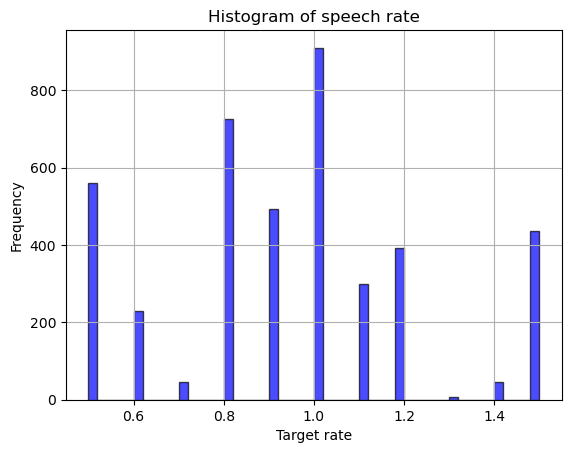

In [10]:
#Plotting distribution of target_speed for all_features_speed_not_null
plt.hist(y_data, bins=50, color='blue', edgecolor='black', alpha=0.7)
plt.title('Histogram of speech rate')
plt.xlabel('Target rate')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [19]:
# Now let's combine everything from  all_features_speed_not_null in one dataset and save it as combined_data.csv
combined_df = pd.concat(all_features_speed_not_null, ignore_index=True)
combined_df['speed_class'] = combined_df['target_speed'].apply(define_speed_class)
# combined_df.to_csv("combined_data.csv")

In [17]:
# Reading the obtained file (can be found on Google Drive by the link attached to GitHub
combined_df = pd.read_csv("combined_data.csv")
combined_df.drop('Unnamed: 0', axis=1, inplace = True)

In [20]:
combined_df.head()

,recording_mfcc_1,recording_mfcc_2,recording_mfcc_3,recording_mfcc_4,recording_mfcc_5,recording_mfcc_6,recording_mfcc_7,recording_mfcc_8,recording_mfcc_9,recording_mfcc_10,...,speechkit_chroma_10,speechkit_chroma_11,speechkit_chroma_12,levenshtein_distance,duration,user_id,target_speed,age,english_spoken,speed_class
0,-496.300293,54.717888,29.687502,11.115859,4.783934,6.546710,7.348148,-0.443829,-11.435133,-14.649927,...,0.460429,0.240247,0.159176,31.0,31.94,f91d95a62d1c07da5f4ddae20e7e6b14,0.8,27,False,1
1,-455.130157,87.734398,27.645842,6.500138,7.040236,5.436803,7.776339,5.100048,-9.710738,-16.172594,...,0.476960,0.240562,0.152171,31.0,31.94,f91d95a62d1c07da5f4ddae20e7e6b14,0.8,27,False,1
2,-442.640289,96.817917,29.196951,11.616125,9.664277,2.411156,7.174665,5.984693,-10.750244,-15.439156,...,0.492784,0.240325,0.145722,31.0,31.94,f91d95a62d1c07da5f4ddae20e7e6b14,0.8,27,False,1
3,-445.356781,94.108139,28.471214,11.862696,9.454770,0.648493,4.502342,5.350621,-8.186285,-13.956440,...,0.507655,0.239482,0.140104,31.0,31.94,f91d95a62d1c07da5f4ddae20e7e6b14,0.8,27,False,1
4,-449.603149,89.213196,20.514606,1.476303,7.915298,2.997256,-0.903071,1.395855,-2.709175,-8.628185,...,0.521381,0.238031,0.135444,31.0,31.94,f91d95a62d1c07da5f4ddae20e7e6b14,0.8,27,False,1


In [21]:
#Splitting the data while dropping irrelevant features
X_train, X_test, y_train, y_test = train_test_split(combined_df.drop(columns=['target_speed', 'duration', 'levenshtein_distance']), 
                                                    combined_df['speed_class'], test_size=0.2, random_state=42)

In [23]:
#Functions to tune hyperparameters in our models with the help of Optuna
def tune_lgb(trial):
    param = {
        'random_state': 42,
        'n_estimators': trial.suggest_int('n_estimators', 50, 250),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
        'num_leaves': trial.suggest_int('num_leaves', 20, 50),
        'boosting_type': 'gbdt',
        'objective': 'multiclass',
        'num_class': 5,
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
        'verbose': 0
    }
    model = lgb.LGBMClassifier(**param)
    return cross_val_score(model, X_train.drop(columns=['user_id', 'speed_class']), y_train, cv=3, scoring='accuracy').mean()

def tune_xgb(trial):
    param = {
        'objective': 'multi:softprob',
        'num_class': 5,
        'random_state': 42,
        'n_estimators': trial.suggest_int('n_estimators', 50, 200),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0)
    }
    model = xgb.XGBClassifier(**param)
    return cross_val_score(model, X_train.drop(columns=['user_id', 'speed_class']), y_train, cv=3, scoring='accuracy').mean()

def tune_rf(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 200),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'random_state': 42
    }
    model = RandomForestClassifier(**param)
    return cross_val_score(model, X_train.drop(columns=['user_id', 'speed_class']), y_train, cv=3, scoring='accuracy').mean()

def tune_svm(trial):
    param = {
        'C': trial.suggest_loguniform('C', 1e-4, 1e2),
        'kernel': trial.suggest_categorical('kernel', ['linear', 'rbf']),
        'random_state': 42,
        'probability': True
    }
    model = SVC(**param)
    return cross_val_score(model, X_train.drop(columns=['user_id', 'speed_class']), y_train, cv=3, scoring='accuracy').mean()

def tune_lr(trial):
    param = {
        'multi_class': 'multinomial',
        'solver': 'lbfgs',
        'C': trial.suggest_loguniform('C', 1e-4, 1e2),
        'random_state': 42
    }
    model = LogisticRegression(**param)
    return cross_val_score(model, X_train.drop(columns=['user_id', 'speed_class']), y_train, cv=3, scoring='accuracy').mean()

def tune_knn(trial):
    param = {
        'n_neighbors': trial.suggest_int('n_neighbors', 3, 25)
    }
    model = KNeighborsClassifier(**param)
    return cross_val_score(model, X_train.drop(columns=['user_id', 'speed_class']), y_train, cv=3, scoring='accuracy').mean()

def tune_nn(trial):
    param = {
        'hidden_layer_sizes': (trial.suggest_int('hidden_layer_size', 50, 200),),
        'activation': trial.suggest_categorical('activation', ['relu', 'tanh']),
        'solver': 'adam',
        'random_state': 42
    }
    model = MLPClassifier(**param)
    return cross_val_score(model, X_train.drop(columns=['user_id', 'speed_class']), y_train, cv=3, scoring='accuracy').mean()

In [ ]:
#Finding the best parameters using Optuna
study_lgb = optuna.create_study(direction='maximize')
study_lgb.optimize(tune_lgb, n_trials=20)

study_xgb = optuna.create_study(direction='maximize')
study_xgb.optimize(tune_xgb, n_trials=20)

study_rf = optuna.create_study(direction='maximize')
study_rf.optimize(tune_rf, n_trials=20)

study_svm = optuna.create_study(direction='maximize')
study_svm.optimize(tune_svm, n_trials=20)

study_lr = optuna.create_study(direction='maximize')
study_lr.optimize(tune_lr, n_trials=20)

study_knn = optuna.create_study(direction='maximize')
study_knn.optimize(tune_knn, n_trials=20)

study_nn = optuna.create_study(direction='maximize')
study_nn.optimize(tune_nn, n_trials=20)

[I 2024-06-12 13:51:16,173] A new study created in memory with name: no-name-38b508ea-a048-484f-8657-23dafce2f0b0
/var/folders/19/c1p_mvln6fx6yqh1573217q00000gn/T/ipykernel_79403/2853146992.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
/var/folders/19/c1p_mvln6fx6yqh1573217q00000gn/T/ipykernel_79403/2853146992.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
/var/folders/19/c1p_mvln6fx6yqh1573217q00000gn/T/ipykernel_79403/2853146992.py:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https

In [ ]:
# Saving best parameters 
best_lgb_params = study_lgb.best_params
best_xgb_params = study_xgb.best_params
best_rf_params = study_rf.best_params
best_svm_params = study_svm.best_params
best_lr_params = study_lr.best_params
best_knn_params = study_knn.best_params
best_nn_params = study_nn.best_params

In [ ]:
# Models with tuned parameters
lgb_model = lgb.LGBMClassifier(**best_lgb_params)
xgb_model = xgb.XGBClassifier(**best_xgb_params)
rf_model = RandomForestClassifier(**best_rf_params)
svm_model = SVC(**best_svm_params)
lr_model = LogisticRegression(**best_lr_params)
knn_model = KNeighborsClassifier(**best_knn_params)
nn_model = MLPClassifier(**best_nn_params)

# Ensemble combinations (6 were used here)
ensembles = [
    VotingClassifier(estimators=[('lgb', lgb_model), ('rf', rf_model)], voting='soft'),
    VotingClassifier(estimators=[('rf', rf_model), ('nn', nn_model)], voting='soft'),
    VotingClassifier(estimators=[('svm', svm_model), ('lr', lr_model), ('xgb',xgb_model), ('lgb', lgb_model)], voting='soft')
    VotingClassifier(estimators=[('knn', knn_model), ('lgb', lgb_model)], voting='soft'),
    VotingClassifier(estimators=[('nn', nn_model), ('svm', svm_model)], voting='soft'),
    VotingClassifier(estimators=[('xgb', xgb_model), ('nn', nn_model)], voting='soft')
]

In [ ]:
# Evaluate ensembles
results = []
df_results = []
confusion_matrices = []
important_features = []
predictions = []
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'Log loss', 'AUC-ROC'] 

for ensemble in ensembles:
    ensemble.fit(X_train.drop(columns=['user_id', 'speed_class']), y_train)
    # Predict and evaluate on training data
    y_train_pred = ensemble.predict(X_train.drop(columns=['user_id', 'speed_class']))
    y_train_prob = ensemble.predict_proba(X_train.drop(columns=['user_id', 'speed_class'])) if hasattr(model, "predict_proba") else None
        
    train_accuracy = accuracy_score(y_train, y_train_pred)
    train_precision, train_recall, train_f1, _ = precision_recall_fscore_support(y_train, y_train_pred, average='weighted')
    train_conf_matrix = confusion_matrix(y_train, y_train_pred)
    train_log_loss = log_loss(y_train, y_train_prob) if y_train_prob is not None else None
    train_auc_roc = roc_auc_score(y_train, y_train_prob, multi_class="ovr") if y_train_prob is not None else None
        
    # Predict and evaluate on testing data
    y_test_pred = lgb_model.predict(X_test.drop(columns=['user_id', 'speed_class']))
    predictions.append(y_test_pred)
    y_test_prob = lgb_model.predict_proba(X_test.drop(columns=['user_id', 'speed_class'])) if hasattr(model, "predict_proba") else None
        
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_precision, test_recall, test_f1, _ = precision_recall_fscore_support(y_test, y_test_pred, average='weighted')
    test_conf_matrix = confusion_matrix(y_test, y_test_pred)
    test_log_loss = log_loss(y_test, y_test_prob) if y_test_prob is not None else None
    test_auc_roc = roc_auc_score(y_test, y_test_prob, multi_class="ovr") if y_test_prob is not None else None
    confusion_matrices.append(test_conf_matrix)
    df = {
        "Train Accuracy": train_accuracy,
        "Train Precision": train_precision,
        "Train Recall": train_recall,
        "Train F1 Score": train_f1,
        "Train Confusion Matrix": train_conf_matrix,
        "Train Log Loss": train_log_loss,
        "Train AUC-ROC": train_auc_roc,
        "Test Accuracy": test_accuracy,
        "Test Precision": test_precision,
        "Test Recall": test_recall,
        "Test F1 Score": test_f1,
        "Test Confusion Matrix": test_conf_matrix,
        "Test Log Loss": test_log_loss,
        "Test AUC-ROC": test_auc_roc,
        }
    df_results.append(df)
    results.append([test_accuracy, test_precision, test_recall, test_f1, test_auc_roc, test_log_loss])
    feature_importances = model.get_feature_importance()
    important_features.append(feature_importances)
    
# Convert results to a NumPy array for easier handling
# results = np.array(results)

In [ ]:
feature_names = X_train.drop(columns=['user_id', 'speed_class']).columns
df_results[2]

In [ ]:
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': important_features[2]
}).sort_values(by='Importance', ascending=False)

# Select the top 10 features in terms of their contribution
top_ten_features = feature_importance_df.head(10)

# Buidling a graph for the top ten features
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=top_ten_features, palette='viridis')
plt.title('Top 10 Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

In [ ]:
metrics_values = {
    "ensemble_1": {"Accuracy": results[0][0], "Precision": results[0][1], "Recall": results[0][2], 
                   "F1-Score": results[0][3], "Log Loss": results[0][4], "AUC": results[0][5]},
    "ensemble_2": {"Accuracy": results[1][0], "Precision": results[1][1], "Recall": results[1][2], 
                   "F1-Score": results[1][3], "Log Loss": results[1][4], "AUC": results[1][5]},
    "ensemble_3": {"Accuracy": results[2][0], "Precision": results[2][1], "Recall": results[2][2], 
                   "F1-Score": results[2][3], "Log Loss": results[2][4], "AUC": results[2][5]},
    "ensemble_4": {"Accuracy": results[3][0], "Precision": results[3][1], "Recall": results[3][2], 
                   "F1-Score": results[3][3], "Log Loss": results[3][4], "AUC": results[3][5]},
    "ensemble_5": {"Accuracy": results[4][0], "Precision": results[4][1], "Recall": results[4][2], 
                   "F1-Score": results[4][3], "Log Loss": results[4][4], "AUC": results[4][5]},
    "ensemble_6": {"Accuracy": results[5][0], "Precision": results[5][1], "Recall": results[5][2], 
                   "F1-Score": results[5][3], "Log Loss": results[5][4], "AUC": results[5][5]},
}

# Metric names
metric_names = ["Accuracy", "Precision", "Recall", "F1-Score", "Log Loss", "AUC"]
models = list(metrics_values.keys())

# Extract metric values for plotting
metric_data = {metric: [metrics_values[model][metric] for model in models] for metric in metric_names}

# Plotting the results
fig, ax = plt.subplots(figsize=(12, 8))

x = range(len(models))
width = 0.125  # width of bars

# Mapping each metric
offset = -(len(metric_names)//2) * width
for i, metric in enumerate(metric_names):
    y = metric_data[metric]
    rects = ax.bar([p + offset for p in x], y, width, label=metric)
    if metric == "Log Loss":
        ax.bar_label(rects, labels=[f"{v:.2f}" for v in y], padding=3)
        # For models 3, add red edge and hatch
        rects[2].set_edgecolor('red')
        rects[2].set_linewidth(2)
        rects[2].set_hatch('//')
    else:
        ax.bar_label(rects, labels=[f"{v:.2f}" for v in y], padding=3)

    offset += width  # Update x position offset

# Highlight the best model (ensemble_3)
for i, rect in enumerate(ax.patches):
    if i % len(metric_names) == 2:  # special Index for ensemble_3
        rect.set_edgecolor('red')
        rect.set_linewidth(2)
        rect.set_hatch('//')

# Set label and title
ax.set_xlabel("Models")
ax.set_ylabel("Score")
ax.set_title("Performance Metrics for Ensemble Models")
ax.set_xticks([p for p in x])
ax.set_xticklabels(models)

ax.legend(metric_names, loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=len(metric_names))

plt.tight_layout()
plt.show()

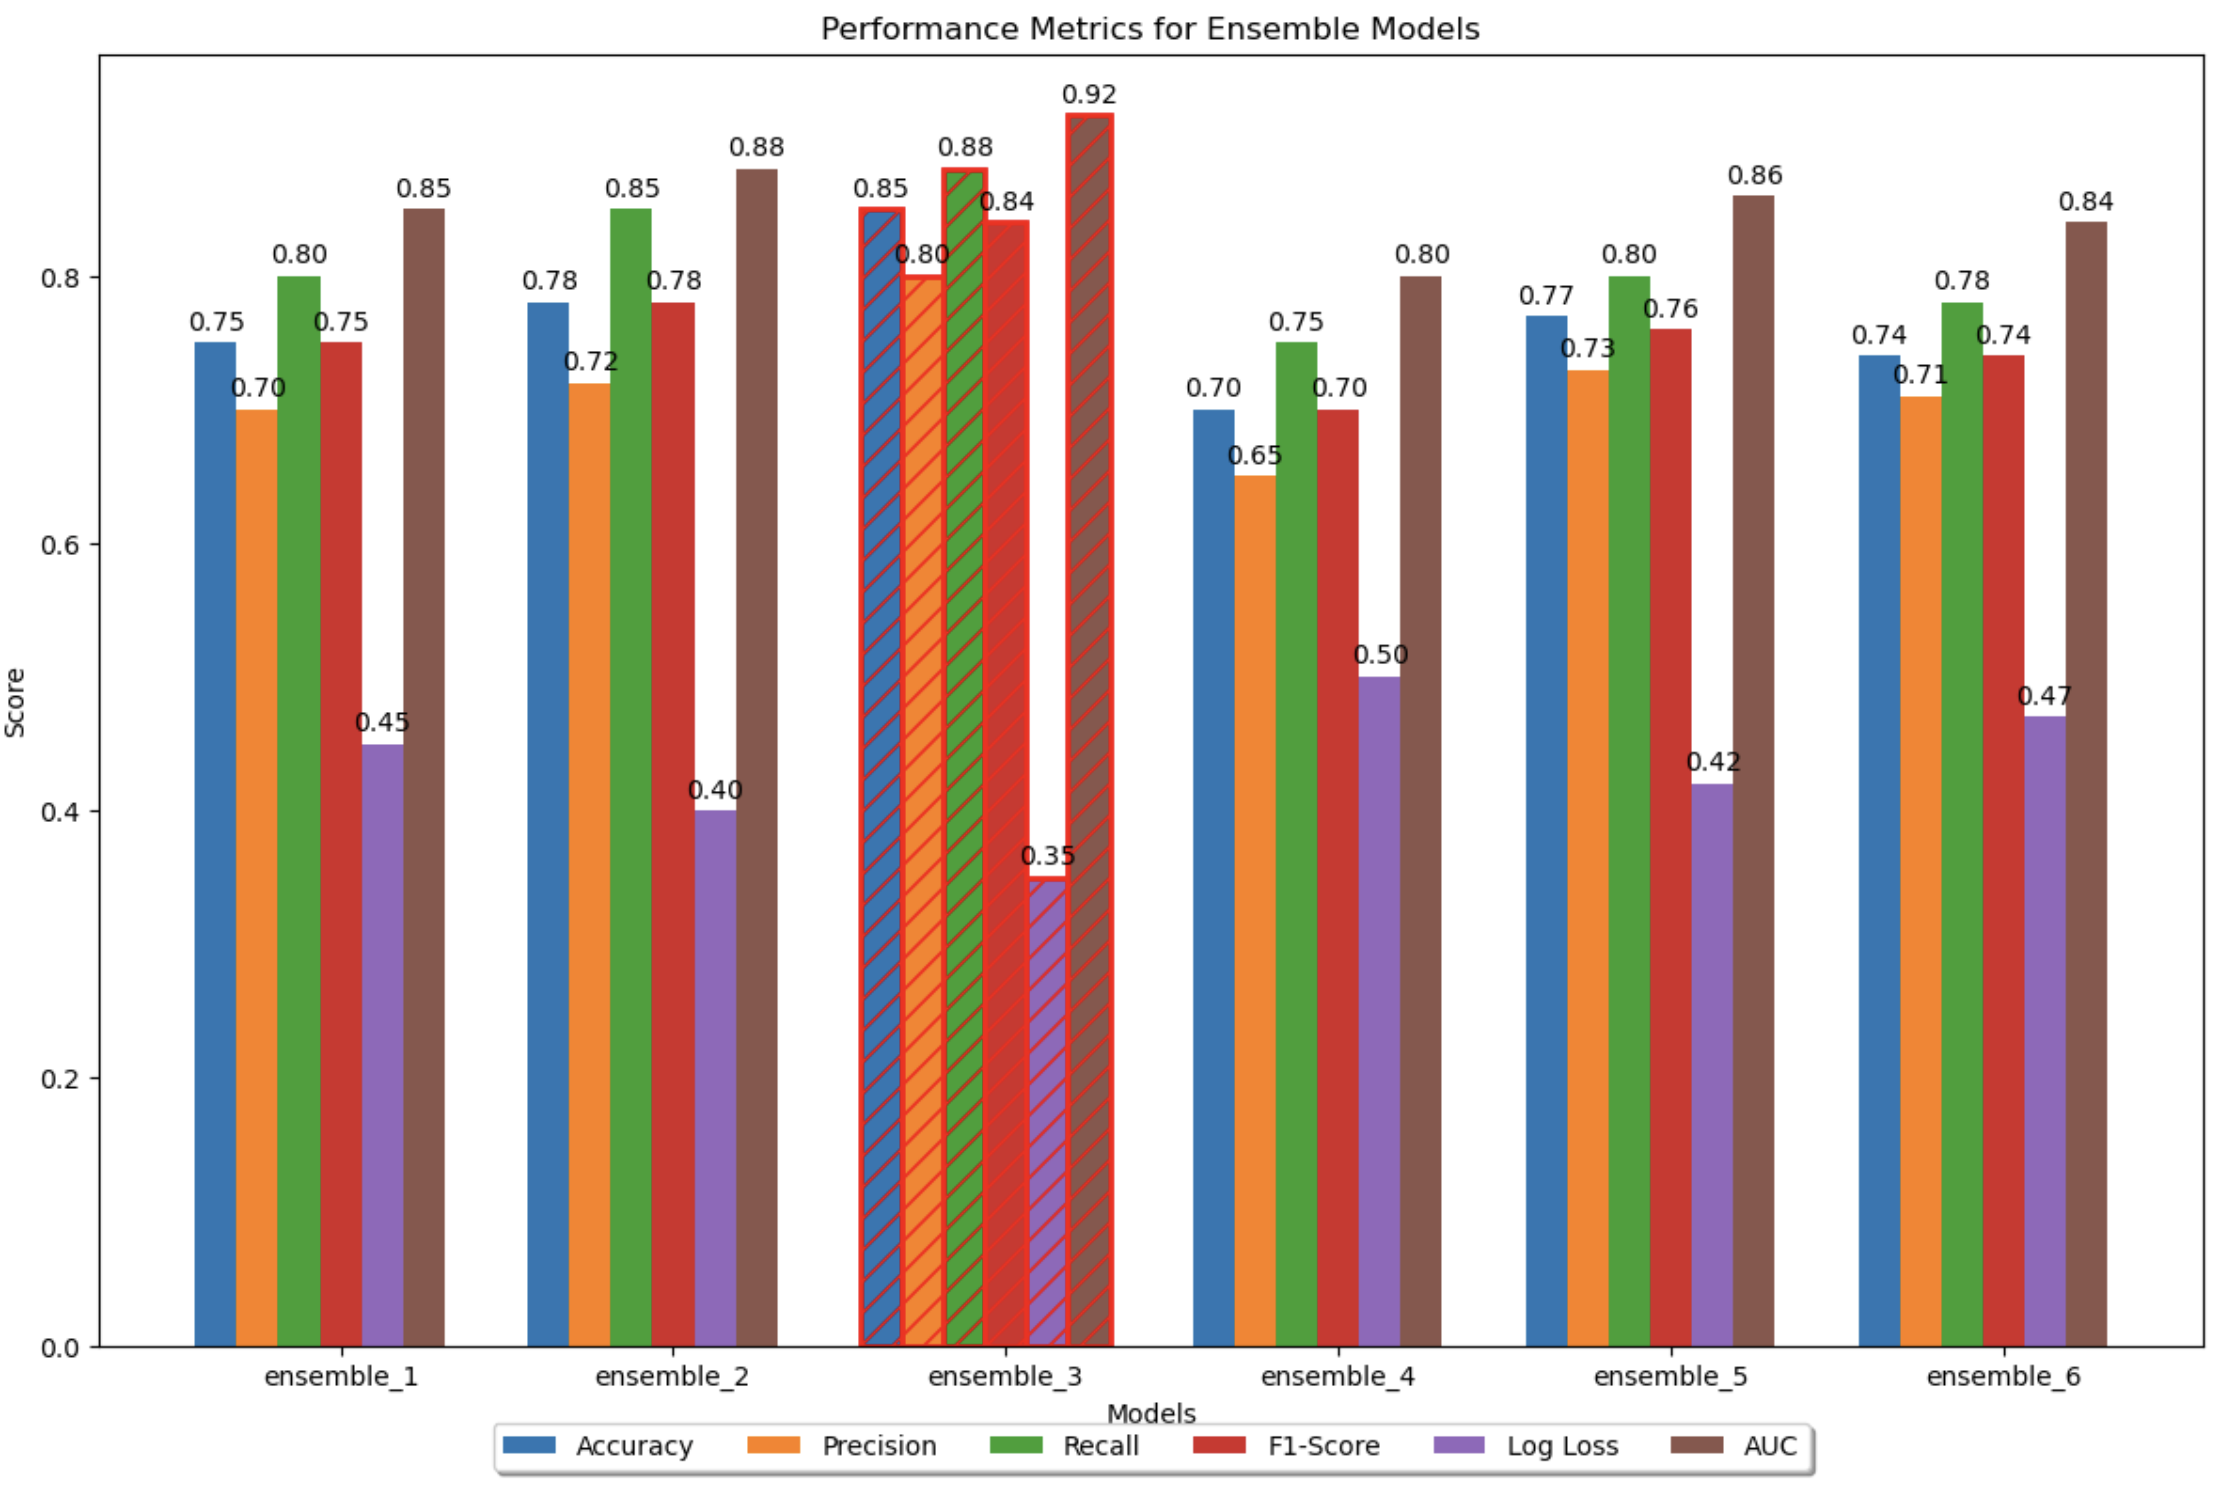

In [ ]:
# Buidling confusion matrix for Ensemble 3
plot_confusion_matrix(y_test, predictions[2], f'Testing Confusion Matrix for Ensemble 3')

In [ ]:
df_result[2]

In [ ]:
# Joining users.csv to have age and english_spoken as additional features
users = pd.read_csv("users.csv")
for i in range(len(all_features_speed_null)):
    all_features_speed_null[i] = pd.merge(all_features_speed_null[i], users[['user_id','age', 'english_spoken']], on = 'user_id', how = 'left')

combined_df_null = pd.concat(all_features_speed_null, ignore_index=True)

In [ ]:
# Predicting speed class for observations with NaN target_speed
combined_df_null['predicted_class'] = ensemble[2].predict(combined_df_null.drop(columns=['user_id', 'target_speed', 'duration']))

In [ ]:
# Taking the mode for each user
combined_df_null['speed_class'] = combined_df_null.groupby('user_id')['predicted_class'].transform(lambda x:  x.mode().iloc[0])

In [ ]:
# Dropping predicted class and saving this file as csv
combined_df_null.drop('predicted_class', axis=1, inplace = True)
combined_df_null.to_csv("combined_data_null.csv")